# DL_HW3

In [23]:
import numpy as np
import pandas as pd
import os, cv2, time
from imageio import imread, imwrite
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
# from .autonotebook import tqdm as notebook_tqdm
import multiprocessing
from multiprocessing import Pool

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

# prune
import torch.nn.utils.prune as prune


In [24]:
cpus = multiprocessing.cpu_count()
print(cpus)
print(torch.cuda.is_available()) 
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

160
True
Training on device cuda.


## Read Data

In [25]:
# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

In [26]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = np.array(pd.read_table('train.txt', header = None, sep = ' '))
val_idx = np.array(pd.read_table('val.txt', header = None, sep = ' '))
test_idx = np.array(pd.read_table('test.txt', header = None, delimiter = ' '))
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
train_onehot_y = self_onehot(train_y)
val_onehot_y = self_onehot(val_y)
test_onehot_y = self_onehot(test_y)

with Pool(processes = 80) as p:
    train_pic = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
    val_pic = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
    test_pic = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))

train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

os.chdir('/home/rita/111/111-2DL/HW3')

100%|██████████| 450/450 [00:00<00:00, 1085.30it/s]


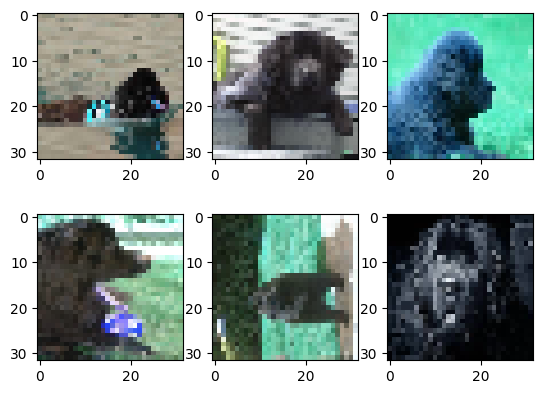

In [31]:
# print img
plt.subplot(2, 3, 1)
img = Image.fromarray(train_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 2)
img = Image.fromarray(val_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 3)
img = Image.fromarray(test_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 4)
img = Image.fromarray(train_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 5)
img = Image.fromarray(val_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 6)
img = Image.fromarray(test_pic[1].astype(np.uint8))
plt.imshow(img)

## PyTorch Lenet5

In [32]:
train_x = train_pic
val_x = val_pic
test_x = test_pic

train_x_tensor = torch.tensor(train_x).to(torch.float32)
val_x_tensor = torch.tensor(val_x).to(torch.float32)
test_x_tensor = torch.tensor(test_x).to(torch.float32)

train_x_tensor = torch.permute(train_x_tensor, (0, 3, 1, 2))
val_x_tensor = torch.permute(val_x_tensor, (0, 3, 1, 2))
test_x_tensor = torch.permute(test_x_tensor, (0, 3, 1, 2))

train_y_tensor = torch.tensor(train_y).to(torch.float32)
val_y_tensor = torch.tensor(val_y).to(torch.float32)
test_y_tensor = torch.tensor(test_y).to(torch.float32)

train_dataset_tensor = Data.TensorDataset(train_x_tensor, train_y_tensor)
val_dataset_tensor = Data.TensorDataset(val_x_tensor, val_y_tensor)
test_dataset_tensor = Data.TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 32
train_loader = DataLoader(
    dataset = train_dataset_tensor,
    batch_size = batch_size,
    shuffle = True,
    # num_workers = 4
)

val_loader = DataLoader(
    dataset = val_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

test_loader = DataLoader(
    dataset = test_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

print(type(train_dataset_tensor))
print(type(train_x_tensor))
print(torch.__version__)

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.Tensor'>
1.13.0+cu117


In [33]:
class Lenet5_PyTorch(nn.Module) :
    def __init__(self, n_channel = 6):
        super().__init__() # (3, 32, 32)
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5) # (6, 28, 28)
        # self.conv1_bn = nn.BatchNorm2d()
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5) # (16, 10, 10)
        # self.conv2_bn = nn.BatchNorm2d()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)
    
    def forward(self, x) :
        out = F.max_pool2d(torch.sigmoid(self.conv1(x)), 2) # (6, 14, 14)
        # out = nn.functional.relu(self.conv1_bn(out))
        out = F.max_pool2d(torch.sigmoid(self.conv2(out)), 2) # (16, 5, 5)
        # out = nn.functional.relu(self.conv2_bn(out))
        out = out.view(out.size(0), -1)
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = torch.softmax(self.fc3(out), dim = 1)
        return out

In [34]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader = None):
    ls_train_loss = []
    ls_train_acc = []
    ls_val_loss = []
    ls_val_acc = []
    for epoch in range(1, n_epochs + 1):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0
        correct = 0
        total = 0
        
        loop = tqdm(enumerate(train_loader), total = len(train_loader))
        for i, (imgs, labels) in loop : 
            imgs = imgs.to(device = device) 
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device = device)
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) 
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            train_loss += loss.item() * labels.shape[0]
            
            loop.set_description(f'Epoch[{epoch} / {n_epochs}]')
            if ((i+1 == len(train_loader)) and (val_loader != None)) :
                train_acc = correct / total
                train_loss /= total
                val_acc, val_loss = validate(model, loss_fn, val_loader)
            
            loop.set_postfix(loss = train_loss, acc = train_acc, val_loss = val_loss, val_acc = val_acc)
        ls_train_acc.append(train_acc)
        ls_train_loss.append(train_loss)
        ls_val_acc.append(val_acc)
        ls_val_loss.append(val_loss)
        
    return model, ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss
        
            
def validate(model, loss_fn, loader):
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad(): 
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            loss += loss_fn(outputs, labels).item() * labels.shape[0]
            # print(predicted,  '\n')    
    acc = correct / total
    loss /= total
    # print("Accuracy : {:.2f}, Loss : {:.2f}".format(acc, loss)) 
        
    return acc, loss

In [9]:
# https://pytorch.org/tutorials/intermediate/pruning_tutorial.html
# train a model
# save the trained model # (trained_model.model)
# load the trained model and prune it
# save the pruned model # (pruned_model.model)
# load the pruned model and train it

Epoch[30 / 30]: 100%|██████████| 1979/1979 [00:09<00:00, 204.91it/s, acc=0.138, loss=3.81, val_acc=0.129, val_loss=3.82]


65406
Accuracy before Prune :  0.05333333333333334
Loss before Prune :  3.887062062157525


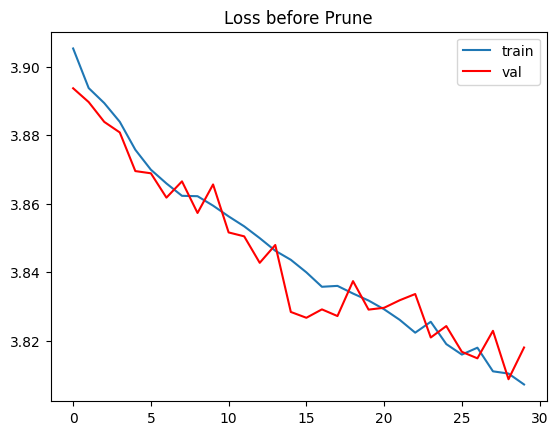

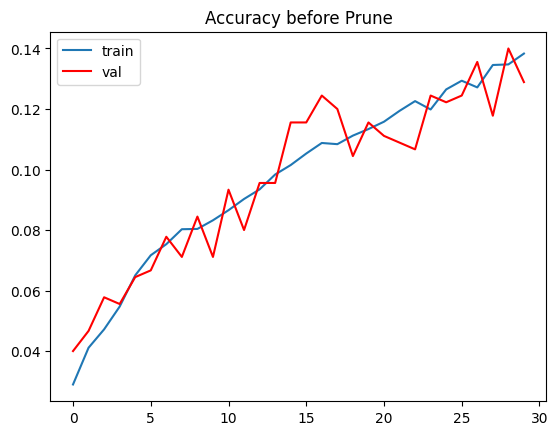

Sparsity in conv1.weight: 25.78%
Sparsity in conv2.weight: 25.96%
Sparsity in fc1.weight: 21.86%
Sparsity in fc2.weight: 14.71%
Sparsity in fc3.weight: 7.45%
Global sparsity: 20.00%


Epoch[30 / 30]: 100%|██████████| 1979/1979 [00:10<00:00, 190.93it/s, acc=0.203, loss=3.75, val_acc=0.164, val_loss=3.78]


65406
Accuracy after Prune :  0.16444444444444445
Loss after Prune :  3.7773023467593725


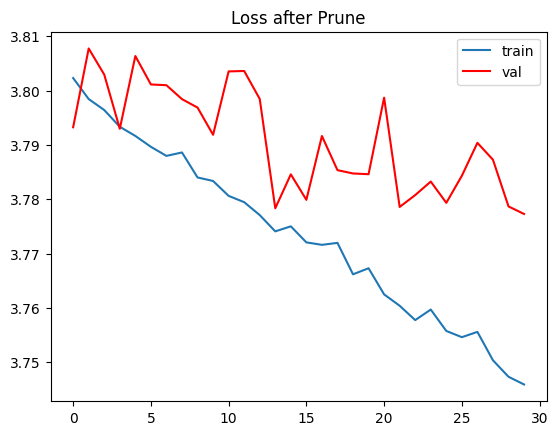

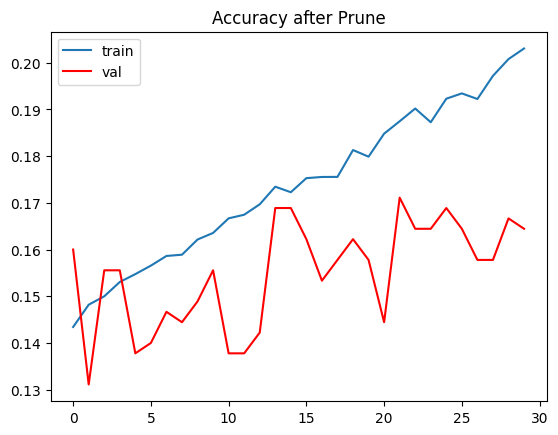

In [17]:
# another try
model = Lenet5_PyTorch().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  
loss_fn = nn.CrossEntropyLoss() 
n_epochs = 30

model, ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
acc_val_before_prune, loss = validate(loaded_model, loss_fn, val_loader)
print('Accuracy before Prune : ', acc_val_before_prune)
print('Loss before Prune : ', loss)

# draw
plt.title('Loss before Prune')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_loss_before Prune.png')
# plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy before Prune')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_acc_before Prune.png')
# plt.show()
torch.save(model.state_dict(), './model/cnn_adam_v1_prune.pt')

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

print("Sparsity in conv1.weight: {:.2f}%".format(
    100. * float(torch.sum(model.conv1.weight == 0))/ float(model.conv1.weight.nelement())))
print("Sparsity in conv2.weight: {:.2f}%".format(
    100. * float(torch.sum(model.conv2.weight == 0))/ float(model.conv2.weight.nelement())))
print("Sparsity in fc1.weight: {:.2f}%".format(
    100. * float(torch.sum(model.fc1.weight == 0))/ float(model.fc1.weight.nelement())))
print("Sparsity in fc2.weight: {:.2f}%".format(
    100. * float(torch.sum(model.fc2.weight == 0))/ float(model.fc2.weight.nelement())))
print("Sparsity in fc3.weight: {:.2f}%".format(
    100. * float(torch.sum(model.fc3.weight == 0))/ float(model.fc3.weight.nelement())))
print("Global sparsity: {:.2f}%".format(
    100. * float(
        torch.sum(model.conv1.weight == 0)
        + torch.sum(model.conv2.weight == 0)
        + torch.sum(model.fc1.weight == 0)
        + torch.sum(model.fc2.weight == 0)
        + torch.sum(model.fc3.weight == 0)
    )
    / float(
        model.conv1.weight.nelement()
        + model.conv2.weight.nelement()
        + model.fc1.weight.nelement()
        + model.fc2.weight.nelement()
        + model.fc3.weight.nelement()
    )))

# model = Lenet5_PyTorch().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  
loss_fn = nn.CrossEntropyLoss() 

model, ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
acc_val_after_prune, loss = validate(model, loss_fn, val_loader)
print('Accuracy after Prune : ', acc_val_after_prune)
print('Loss after Prune : ', loss)

# draw
plt.title('Loss after Prune')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_loss_after Prune.png')
# plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy after Prune')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_acc_after Prune.png')
# plt.show()

torch.save(model.state_dict(), './model/cnn_adam_v1_afterprune.pt')

In [18]:
loss_fn = nn.CrossEntropyLoss() 

model = Lenet5_PyTorch().to(device)
model.load_state_dict(torch.load('./model/cnn_adam_v1_prune.pt'))
acc, loss = validate(model, loss_fn, test_loader)
print('Accuracy after Prune : ', acc)
print('Loss after Prune : ', loss)

# prune
model = Lenet5_PyTorch().to(device)
parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

model.load_state_dict(torch.load('./model/cnn_adam_v1_afterprune.pt'))
acc, loss = validate(model, loss_fn, test_loader)
print('Accuracy after Prune : ', acc)
print('Loss after Prune : ', loss)

# print(model.parameters)

Accuracy after Prune :  0.13555555555555557
Loss after Prune :  3.8136847580803765
Accuracy after Prune :  0.16444444444444445
Loss after Prune :  3.785433627234565


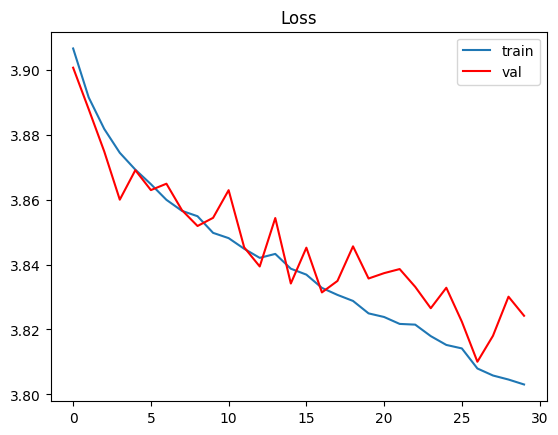

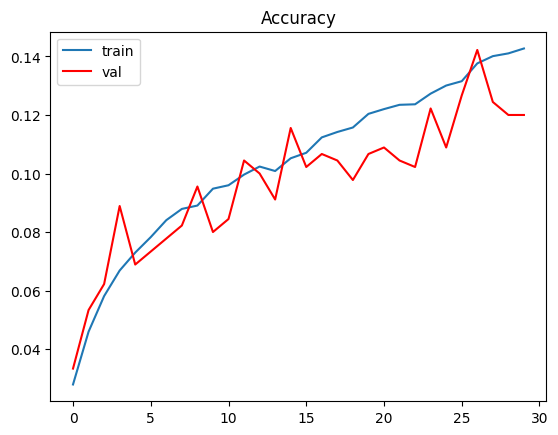

In [21]:
# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_acc.png')
plt.show()

/tmp/ipykernel_774420/2161046234.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_loss_before Prune.png')
/tmp/ipykernel_774420/2161046234.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_acc_before Prune.png')


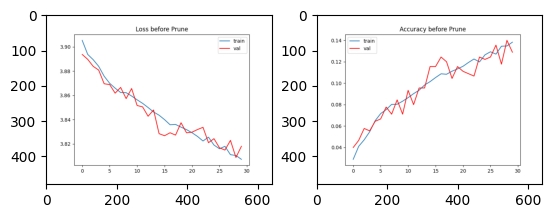

In [20]:
plt.subplot(1, 2, 1)
img = imread('./figure/cnn_loss_before Prune.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./figure/cnn_acc_before Prune.png')
plt.imshow(img)



/tmp/ipykernel_774420/3212259022.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_loss_after Prune.png')
/tmp/ipykernel_774420/3212259022.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_acc_after Prune.png')


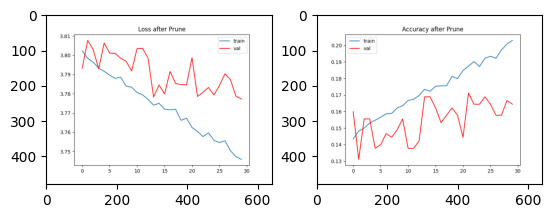

In [21]:
plt.subplot(1, 2, 1)
img = imread('./figure/cnn_loss_after Prune.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./figure/cnn_acc_after Prune.png')
plt.imshow(img)

### Compare

In [37]:
import time
# https://github.com/sovrasov/flops-counter.pytorch
import torchvision.models as models
import torch

# https://www.zhihu.com/question/65305385
# FLOPS：floating point operations per second，意指每秒浮点运算次数，理解为计算速度。是一个衡量硬件性能的指标
# FLOPs：floating point operations的缩写（s表复数），意指浮点运算数，理解为计算量。可以用来衡量算法/模型的复杂度。
from ptflops import get_model_complexity_info

# https://zhuanlan.zhihu.com/p/337810633
from thop import profile

In [48]:
# Pytorch Lenet5 Prune
device = 'cpu'
loaded_model = Lenet5_PyTorch()
loaded_model.load_state_dict(torch.load('./model/cnn_adam_v1.pt'))
loaded_model = loaded_model.to(device)
loss_fn = nn.CrossEntropyLoss() 

# inference time
time_start = time.perf_counter()
acc, loss = validate(loaded_model, loss_fn, val_loader)
print("Time for PyTorch Lenet : {} s".format(time.perf_counter() - time_start))

# Accuracy
print('Accuracy for PyTorch Lenet : ', acc)
print('Loss for PyTorch Lenet : ', loss)

# space complexity
# https://github.com/sovrasov/flops-counter.pytorch
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(loaded_model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))



Time for PyTorch Lenet : 0.06065200502052903 s
Accuracy for PyTorch Lenet :  0.12
Loss for PyTorch Lenet :  3.8242185338338217
Lenet5_PyTorch(
  65.41 k, 100.000% Params, 661.64 KMac, 100.000% MACs, 
  (conv1): Conv2d(456, 0.697% Params, 357.5 KMac, 54.033% MACs, 3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2.42 k, 3.694% Params, 241.6 KMac, 36.515% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(48.12 k, 73.571% Params, 48.12 KMac, 7.273% MACs, in_features=400, out_features=120, bias=True)
  (fc2): Linear(10.16 k, 15.540% Params, 10.16 KMac, 1.536% MACs, in_features=120, out_features=84, bias=True)
  (fc3): Linear(4.25 k, 6.498% Params, 4.25 KMac, 0.642% MACs, in_features=84, out_features=50, bias=True)
)
Computational complexity:       661.64 KMac
Number of parameters:           65.41 k 


In [41]:
loss_fn = nn.CrossEntropyLoss() 

model = Lenet5_PyTorch().to(device)
model.load_state_dict(torch.load('./model/cnn_adam_v1_prune.pt'))
acc, loss = validate(model, loss_fn, test_loader)
print('Accuracy after Prune : ', acc)
print('Loss after Prune : ', loss)

# inference time
time_start = time.perf_counter()
acc_val_before, loss = validate(model, loss_fn, val_loader)
t_before = time.perf_counter() - time_start
print("Time for PyTorch Lenet : {} s".format(t_before))
# Accuracy
print('Accuracy for PyTorch Lenet : ', acc_val_before)
print('Loss for PyTorch Lenet : ', loss)
acc_test_before, loss = validate(model, loss_fn, test_loader)

with torch.cuda.device(0):
  macs_before, params_before = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs_before))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params_before))

# space complexity & FLOPS
# https://github.com/Lyken17/pytorch-OpCounter
input = torch.randn(32, 3, 32, 32).to(device)
macs__before, params_before = profile(model, inputs=(input, ))
print()
print(f"FLOPs: {macs__before*2/1e6} MFLOPs, params: {params_before/1e6} M")


# prune
model = Lenet5_PyTorch().to(device)
parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

model.load_state_dict(torch.load('./model/cnn_adam_v1_afterprune.pt'))
acc_test_after, loss = validate(model, loss_fn, test_loader)
print('Accuracy after Prune : ', acc_test_after)
print('Loss after Prune : ', loss)

# inference time
time_start = time.perf_counter()
acc_val_after, loss = validate(model, loss_fn, val_loader)
t_after = time.perf_counter() - time_start
print("Time for PyTorch Lenet : {} s".format(t_after))
# Accuracy
print('Accuracy for PyTorch Lenet : ', acc_val_after)
print('Loss for PyTorch Lenet : ', loss)
acc_test_after, loss = validate(model, loss_fn, test_loader)

with torch.cuda.device(0):
  macs_after, params_after = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs_after))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params_after))

# space complexity & FLOPS
# https://github.com/Lyken17/pytorch-OpCounter
input = torch.randn(32, 3, 32, 32).to(device)
macs__after, params_after = profile(model, inputs=(input, ))
print()
print(f"FLOPs: {macs__after*2/1e6} MFLOPs, params: {params_after/1e6} M")
# print(model.parameters)

Accuracy after Prune :  0.13555555555555557
Loss after Prune :  3.8136847580803765
Time for PyTorch Lenet : 0.017752556945197284 s
Accuracy for PyTorch Lenet :  0.1288888888888889
Loss for PyTorch Lenet :  3.818039548661974
Lenet5_PyTorch(
  65.41 k, 100.000% Params, 661.64 KMac, 100.000% MACs, 
  (conv1): Conv2d(456, 0.697% Params, 357.5 KMac, 54.033% MACs, 3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2.42 k, 3.694% Params, 241.6 KMac, 36.515% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(48.12 k, 73.571% Params, 48.12 KMac, 7.273% MACs, in_features=400, out_features=120, bias=True)
  (fc2): Linear(10.16 k, 15.540% Params, 10.16 KMac, 1.536% MACs, in_features=120, out_features=84, bias=True)
  (fc3): Linear(4.25 k, 6.498% Params, 4.25 KMac, 0.642% MACs, in_features=84, out_features=50, bias=True)
)
Computational complexity:       661.64 KMac
Number of parameters:           65.41 k 
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'

In [46]:
temp = pd.DataFrame(columns = ['Before Prune', 'After Prune'], index = ['Accuracy Test', 'Accuracy Val', 'Inference Time', 'Space Complexity', 'FLOPS'])
temp.to_csv('prune.csv')
# temp = pd.read_csv('prune.csv', index_col = [0])
temp.at['Accuracy Test', 'Before Prune'] = acc_test_before
temp.at['Accuracy Val', 'Before Prune'] = acc_val_before
temp.at['Inference Time', 'Before Prune'] = t_before
temp.at['Space Complexity', 'Before Prune'] = macs_before[:-5]
temp.at['FLOPS', 'Before Prune'] = macs__before*2/1e6

temp.at['Accuracy Test', 'After Prune'] = acc_test_after
temp.at['Accuracy Val', 'After Prune'] = acc_val_after
temp.at['Inference Time', 'After Prune'] = t_after
temp.at['Space Complexity', 'After Prune'] = macs_after[:-5]
temp.at['FLOPS', 'After Prune'] = macs__after*2/1e6
print(temp)
temp.to_csv('prune.csv')


                 Before Prune After Prune
Accuracy Test        0.135556    0.164444
Accuracy Val         0.128889    0.164444
Inference Time       0.017753    0.019697
Space Complexity       661.64      661.64
FLOPS                41.92512    41.92512


20962560.0